# Homework 12

## ASTR 5900, Fall 2017, University of Oklahoma

### Neural Networks

# Problem 1

Imagine a neural network that has already been trained to classify configurations of classical spins in a lattice as 1 of 2 magnetic phases: ferromagnetic or paramagnetic.  A training set was generated using Monte Carlo at a range of temperatures, and the target classifications were determined based on their temperatures relative to the known critical temperature for the 2D ferromagnetic Ising model with Hamiltonian $$ H = -J\sum_{\langle i,j \rangle} \sigma^z_i \sigma^z_j $$
where $\sigma^z_k = \{-1, 1 \}$ is the spin at site $k$ and the summation is over adjacent spin sites (sites that share an edge).  This Hamiltonian says there is energy stored between adjacent sites with opposite spins.  Because of this, at low temperatures the spins generally point in a single direction (either up or down).  As the temperature increases and crosses the critical temperature $T_C$, this aggregate behavior suddenly fades and the Ising system becomes disordered with an average magnetization of zero.  This happens because at higher temperatures the lattice is more likely to reach configurations with high energy (ie those with opposing spins next to each other).


### Part A

In this problem we want to locate the critical temperature of the Ising model.  To do this we will study the output of the trained neural net mentioned in the above prompt from a series of samples that we will generate at various temperatures.

In this problem we will study square lattices of size $10 \times 10$ with periodic boundary conditions.

Write 3 python functions that will be used to create our spin samples.  The first function `energy` should take a spin configuration (an array of 1's and -1's) and the return its energy as determined from the Hamiltonian above.  The second is the `metropolis` function which takes a temperature as an argument and returns a set of spin configurations sampled at that temperature.  This must be performed using an Metropolis-Hastings algorithm, described below:

1.  Initialize a uniform spin configuration $s$.
2. Loop $n$ times
    1. Generate a neighboring spin configuration $s'$ that's a 'neighbor' of $s$
    2. Assign variable `a` = $\text{min}(1, \exp(\frac{E_i - E_j}{T}))$ 
    3. With probability `a` accept state $s'$ and store it in your sample array.  If rejected, store $s$.
3. Return the array of stored states

The third function is `neighbor` and it returns a 'neighboring' state that is close to the input state.  It takes a state as an argument, makes a copy of it with `numpy.copy`, and flips the spin of 3 random sites in the copied state.  The altered state is then returned.

In [28]:
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import pickle
import random
import multiprocessing as mp

#The amount of processors in the computer.
N_processors = mp.cpu_count() -1
#We want to use a maximum of 10 processors.
if N_processors > 10:
    N_processors = 9

print("Num cores: {}".format(N_processors))

Num cores: 7


In [59]:
class methas(object):
    '''
    Main class for the metropolis hastings algorithm
    '''
    def __init__(self,size,configs,alters=3):
        self.spin = np.ones(size)
        self.configs = configs
        self.prob  = 1
        self.alters = alters
        
    def __call__(self,temperature,interaction=1):
        self.j = interaction
        self.t = temperature
        
    def get_params(self):
        return vars(self)
    
    def get_state(self):
        return self.spin
    
    def neighborstate(self):
        '''
        Takes the spin state and returns the altered state
        '''
        tempstate = self.spin.copy()
        for i in range(self.alters):
            shape = tempstate.shape
            row,col = random.randrange(shape[0]),random.randrange(shape[1])
            tempstate[row,col] *= -1.
        self.alteredstate = tempstate.copy()
        
    def hamiltonian(self,state):
        '''
        accepts a state and solves for the energy of the system
        '''
        numrows = len(state)
        numcols = len(state[0])
        energy_rowcol = [] # will store the energy for every site
        for row in range(numrows):
            for col in range(numcols):
                left  = [(col - 1) % numcols, row]
                right = [(col + 1) % numcols, row]
                top   = [col, (row + 1) % numrows]
                below = [col, (row - 1) % numrows]
                sumstate = state[left[0],left[1]]   +\
                           state[right[0],right[1]] +\
                           state[top[0],top[1]]     +\
                           state[below[0],below[1]]
                energy_rowcol.append(sumstate)
        return -1.*self.j*np.sum(energy_rowcol)
        
    def probability(self,e1,e2):
        '''
        determine if the probability for 
        the state to be in new energy
        return the minima between 1 and the probability state
        '''
        dele = e1-e2
        temp = np.exp(dele/self.t)
        #print("Energy: {},{},prob: {}".format(e1,e2,temp))
        self.prob = np.min([1.,temp])
    
    def detstate(self):
        '''
        determine if present state or 
        new state should be accepted
        '''
        if (self.prob >= 1) or (self.prob >= random.random()):
            self.spin = self.alteredstate.copy()            
            
    def main(self):
        '''
        Main metropolis program
        '''
        for i in range(self.configs):
            self.neighborstate()
            e1 = self.hamiltonian(self.spin)
            e2 = self.hamiltonian(self.alteredstate)
            self.probability(e1,e2)
            self.detstate()
        

In [60]:
m = methas((10,10),1000)
m(3,)
print("{}".format(m.get_params()))
m.main()
print("{}".format(m.get_params()))

{'spin': array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]]), 'configs': 1000, 'prob': 1, 'alters': 3, 'j': 1, 't': 3}
{'spin': array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.],
       [ 1.,  1., -1.,  1.,  1.,  1., 

### Part B

It's time to generate data with the functions we just defined and apply it to the trained neural net.  As you know, a standard feed forward neural network is a series of layers of connected neurons that fire (or fractionally fire) based on the linear sum of weights and inputs from their respective previous layer.

The neural network in question has 3 layers: the 100 size input layer (because the input is an spin configuration on a $10 \times 10$ lattice), a hidden layer with 3 perceptrons, and an output layer of 2 perceptrons.  The weights and biases of the first layer are:

$$ W_1 = \frac{1}{N(1 + \epsilon)}
 \begin{pmatrix}
  1 & 1 & \cdots & 1 \\
  -1 & -1 & \cdots & -1 \\
  1 & 1 & \cdots & 1
 \end{pmatrix} \; \; \text{and} \; \; b_1 = \frac{\epsilon}{1+\epsilon} \begin{pmatrix}
  -1 \\
  -1 \\
  1
 \end{pmatrix}$$
 
 This actually works out to be $$ Wx + b = \frac{1}{1 + \epsilon}\begin{pmatrix}
  m(x) - \epsilon \\
  -m(x) - \epsilon \\
  m(x) + \epsilon
 \end{pmatrix}$$
 
 where $m(x) = \frac{1}{N}\sum_i \sigma^z_i$ is the total magnetization of configuration $x$.  $\epsilon$ is a parameter ranging from 0 to 1 that determines how polarized the spins have to be to be classified a one of the ways.  Start with an $ \epsilon $ of 0.3, but feel free to vary it and discuss its effect.  A heaviside step function is applied to each of these elements because they are Perceptrons.
 
The output's weights and biases are:
$$ W_2 = 
 \begin{pmatrix}
  2 & 1 &  -1 \\
      -2 & -2 & 1
 \end{pmatrix} \; \; \text{and} \; \; b_2 =\begin{pmatrix}
  0 \\
    0
 \end{pmatrix}$$

The output features 2 neurons: one that fires if the input is in the cold, ferromagnetic state and the other if the input is in the warm, paramagnetic state.  Write a function `toy_model` that maps an Ising configuration to a vector of length 2 with these specifications.  This function will be the neural net, effectively.

Sample 20 temperatures between 1 and 5 inclusive.  For each temperature, generate 10000 spin configurations with `metropolis`.  Determine the average of each output neuron, and plot the results as a function of temperature on the same figure.  The critical temperature is understood to be at the point in which the lines cross.  What is $T_C$?

In [61]:
def weights(size,epsilon):
    nummatrix = size[0] * size[1]
    weight1 = 1./(1.+epsilon) * (1./nummatrix) * np.array([np.ones(nummatrix),-1*np.ones(nummatrix),np.ones(nummatrix)])
    weight2 = np.array([[2,1,-1],[-2,-2,1]])
    bias1   = epsilon/(1.+epsilon) *np.array([-1,-1,1]).T
    bias2   =np.array([0,0]).T
    return weight1,weight2,bias1,bias2

def main(called,size,configs,temp,intenergy,epsilon):
    print('Temp: {}'.format(temp))
    pos = '{}'.format(temp)
    called[pos] = methas(size,configs)
    called[pos](temp,intenergy)
    called[pos].main()
    state1 = called[pos].get_state().flatten().T
    #print(state1.shape)
    weight1,weight2,bias1,bias2 = weights(size,epsilon)
    #print(weight1.shape,weight2.shape,bias1.shape,bias2.shape)
    tmp1 = np.inner(weight1,state1) + bias1
    #print(tmp1.shape)
    tmp2 = np.inner(weight2,tmp1)   + bias2
    #print(tmp2.shape)
    return tmp2

def toy_model(size,epsilon,temprange,intenergy,configs):
    print('Starting model..')
    called = {}
    pool = mp.Pool(processes = N_processors,maxtasksperchild=10)
    results = [pool.apply_async(main, args=(called,size,configs,temp,intenergy,epsilon)) for temp in temprange]
    temp = [job.get() for job in results]
    print(temp)
    master = [r for r in temp]
    '''
    for temp in temprange:
        print("Temp: {}".format(temp))
        m = methas(size,configs)
        m(temp,intenergy)
        m.main()
        state1 = m.get_state().flatten().T
        #print(state1.shape)
        weight1,weight2,bias1,bias2 = weights(size,epsilon)
        #print(weight1.shape,weight2.shape,bias1.shape,bias2.shape)
        tmp1 = np.inner(weight1,state1) + bias1
        #print(tmp1.shape)
        tmp2 = np.inner(weight2,tmp1)   + bias2
        #print(tmp2.shape)
        master.append(tmp2)
    '''
    print('Finished')
    master = np.array(master).T
    print(master.shape)
    para = master[0,:].copy()
    fero = master[1,:].copy()
    return para,fero

In [62]:
epsilon = 0.3
size = (10,10)
temprange=np.linspace(1,5,50)
intenergy = 1.
configurations = 10000

para,fero = toy_model(size,epsilon,temprange,intenergy,configurations)

Starting model..
Temp: 1.163265306122449
Temp: 1.0
Temp: 1.0816326530612246
Temp: 1.2448979591836735
Temp: 1.4081632653061225
Temp: 1.489795918367347
Temp: 1.3265306122448979
Temp: 1.5714285714285714
Temp: 1.6530612244897958
Temp: 1.7346938775510203
Temp: 1.816326530612245
Temp: 1.8979591836734693
Temp: 1.9795918367346939
Temp: 2.061224489795918
Temp: 2.142857142857143
Temp: 2.224489795918367
Temp: 2.3061224489795915
Temp: 2.387755102040816
Temp: 2.4693877551020407
Temp: 2.5510204081632653
Temp: 2.63265306122449
Temp: 2.7142857142857144
Temp: 2.7959183673469385
Temp: 2.877551020408163
Temp: 2.9591836734693877
Temp: 3.0408163265306123
Temp: 3.1224489795918364
Temp: 3.204081632653061
Temp: 3.2857142857142856
Temp: 3.36734693877551
Temp: 3.4489795918367343
Temp: 3.530612244897959
Temp: 3.6122448979591835
Temp: 3.693877551020408
Temp: 3.7755102040816326
Temp: 3.8571428571428568
Temp: 3.9387755102040813
Temp: 4.020408163265306
Temp: 4.1020408163265305
Temp: 4.183673469387754
Temp: 4.2653061

In [63]:
data = {'para':para,'fero':fero,'temp':temprange}
filename = 'hw12-2.pickle'
with open(filename,'wb') as f:
    pickle.dump(data,f)

In [64]:
data

{'fero': array([ 1.92307692,  1.92307692,  1.90769231,  1.92307692,  1.92307692,
         1.92307692,  1.92307692,  1.92307692,  1.90769231,  1.90769231,
         1.89230769,  1.86153846,  1.90769231,  1.87692308,  1.90769231,
         1.84615385,  1.92307692,  1.89230769,  1.87692308,  1.86153846,
         1.83076923,  1.84615385,  1.84615385,  1.83076923,  1.81538462,
         1.86153846,  1.8       ,  1.84615385,  1.78461538,  1.72307692,
         1.75384615,  1.78461538,  1.81538462,  1.73846154,  1.76923077,
         1.64615385,  1.73846154,  1.72307692,  1.73846154,  1.69230769,
         1.63076923,  1.72307692,  1.75384615,  1.8       ,  1.66153846,
         1.61538462,  1.69230769,  1.67692308,  1.72307692,  1.58461538]),
 'para': array([-0.92307692, -0.92307692, -0.92307692, -0.92307692, -0.92307692,
        -0.92307692, -0.92307692, -0.92307692, -0.92307692, -0.92307692,
        -0.92307692, -0.92307692, -0.92307692, -0.92307692, -0.92307692,
        -0.92307692, -0.92307692,

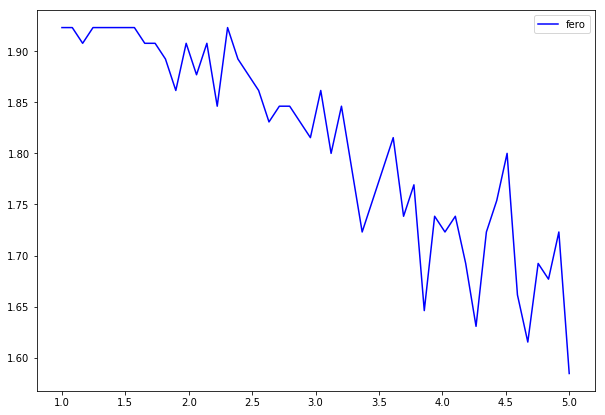

In [65]:
plt.clf()
plt.figure(figsize=[10,7])
#plt.plot(temprange,para,'r-',label='para')
plt.plot(temprange,fero,'b-',label='fero')
plt.legend()
plt.show()

# Problem Z

Comment on the amount of time this assignment required.

## Wording was extremely terrible on this assignment...

5 hours and I know it is wrong
